# Datenaugmentation

## Überblick

Dieses Tutorial demonstriert die Datenerweiterung: eine Technik zur Erhöhung der Vielfalt Ihres Trainingssatzes durch die Anwendung zufälliger (aber realistischer) Transformationen, wie z. B. Bildrotation.

Sie erfahren, wie Sie die Datenerweiterung auf zwei Arten anwenden können:

- Verwenden Sie die Keras-Vorverarbeitungsebenen wie „__tf.keras.layers.Resizing__“, „__tf.keras.layers.Rescaling__“, „__tf.keras.layers.RandomFlip__“ und „__tf.keras.layers.RandomRotation__“.
- Verwenden Sie die „tf.image“-Methoden wie „__tf.image.flip_left_right__“, „__tf.image.rgb_to_grayscale__“, „__tf.image.adjust_brightness_“, „__tf.image.central_crop__“ und „__tf.image“. stateless_random__*`.

## Setup

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

## Laden Sie einen Datensatz herunter

Dieses Tutorial verwendet den Datensatz [tf_flowers](https://www.tensorflow.org/datasets/catalog/tf_flowers). Laden Sie den Datensatz der Einfachheit halber mit [TensorFlow Datasets] (https://www.tensorflow.org/datasets) herunter. Wenn Sie mehr über andere Möglichkeiten zum Importieren von Daten erfahren möchten, schauen Sie sich das Tutorial [Bilder laden](https://www.tensorflow.org/tutorials/load_data/images) an.

In [7]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


Der Blumendatensatz hat fünf Klassen.

In [8]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


Lassen Sie uns ein Bild aus dem Datensatz abrufen und es verwenden, um die Datenerweiterung zu demonstrieren.

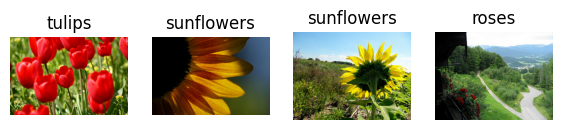

In [10]:
get_label_name = metadata.features['label'].int2str
train_iter = iter(train_ds)
fig = plt.figure(figsize=(7, 8))
for x in range(4):
  image, label = next(train_iter)
  fig.add_subplot(1, 4, x+1)
  plt.imshow(image)
  plt.axis('off')
  plt.title(get_label_name(label));

## Keras-Vorverarbeitungsebenen verwenden

### Größenänderung und Neuskalierung

Sie können die Keras-Vorverarbeitungsebenen verwenden, um die Größe Ihrer Bilder auf eine einheitliche Form zu ändern (mit „tf.keras.layers.Resizing“) und um Pixelwerte neu zu skalieren (mit „tf.keras.layers.Rescaling“).

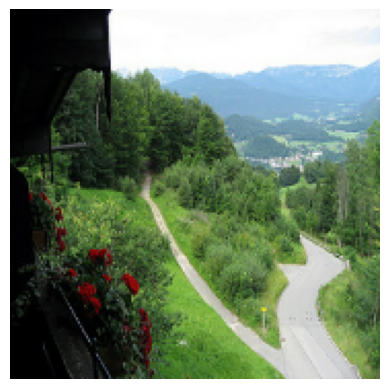

In [19]:
IMG_SIZE = 180

resize_and_rescale = keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

result = resize_and_rescale(image)
plt.axis('off')
plt.imshow(result);

In [16]:
import keras

Stellen Sie sicher, dass die Pixel im Bereich „[0, 1]“ liegen:

In [20]:
print("Min and max pixel values:", result.numpy().min(),result.numpy().max())

Min and max pixel values: 0.0 1.0


### Datenerweiterung / Augemantation

Sie können auch die Keras-Vorverarbeitungsebenen zur Datenerweiterung verwenden, z. B. „tf.keras.layers.RandomFlip“ und „tf.keras.layers.RandomRotation“.

Lassen Sie uns einige Vorverarbeitungsebenen erstellen und diese wiederholt auf dasselbe Bild anwenden.

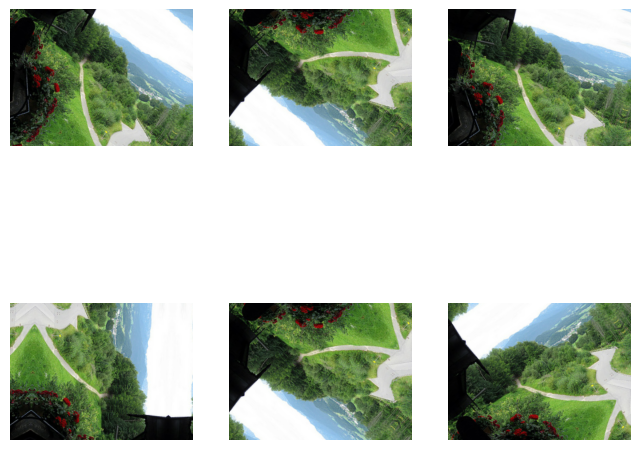

In [32]:
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.4),
])


plt.figure(figsize=(8, 7))
for i in range(6):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(2, 3, i + 1)
  plt.imshow(augmented_image.numpy()/255)
  plt.axis("off")

In [38]:
model = keras.Sequential([
  # Add the preprocessing layers you created earlier.
  resize_and_rescale,
  data_augmentation,
  # Add the model layers
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(1,activation='sigmoid')
])

In [39]:
aug_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [40]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)


train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

In [41]:
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), input_shape=(180,180,3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1,activation='softmax')
])

In [42]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
epochs=1
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

92/92 [==============================] - 116s 1s/step - loss: -3429.6223 - accuracy: 0.1747 - val_loss: -98850.1797 - val_accuracy: 0.1608


In [43]:
loss, acc = model.evaluate(test_ds)

12/12 [==============================] - 4s 301ms/step - loss: -126278.3750 - accuracy: 0.1662


In [44]:
%%capture
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

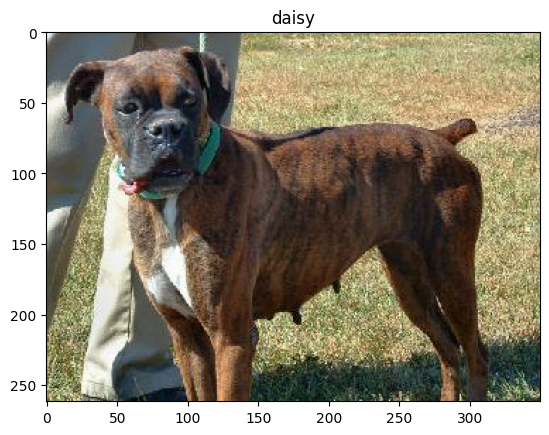

In [45]:
image, label = next(iter(train_ds))
plt.imshow(image)
plt.title(get_label_name(label));

In [46]:
def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)
    plt.axis("off")

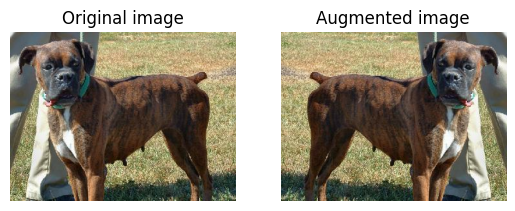

In [47]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

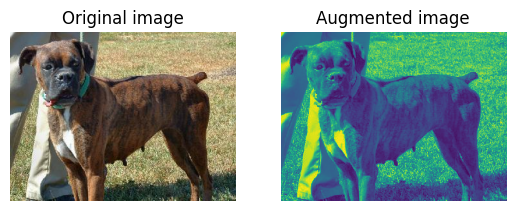

In [48]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image,  tf.squeeze(grayscaled))

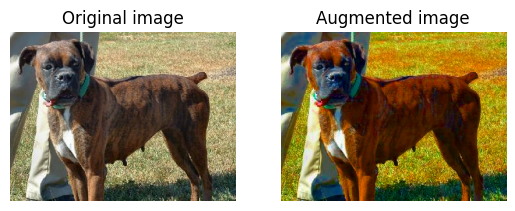

In [49]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

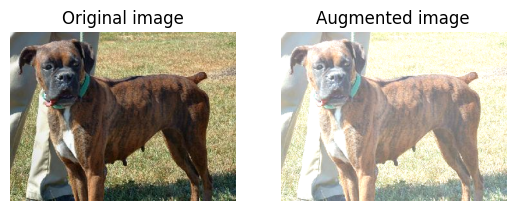

In [50]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

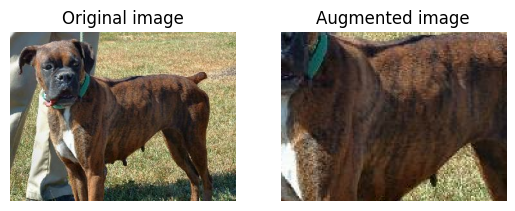

In [51]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image, cropped)

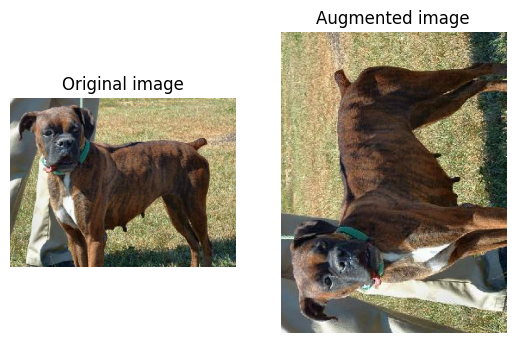

In [52]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

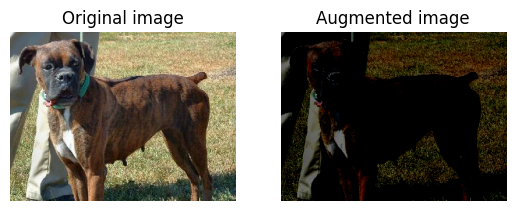

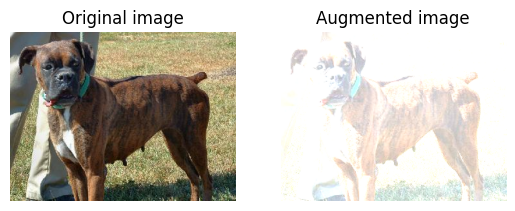

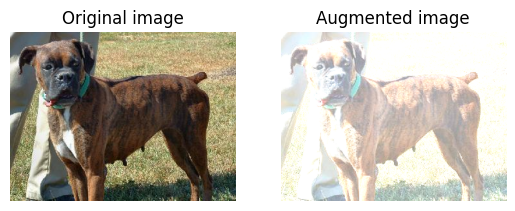

In [53]:
for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_brightness = tf.image.stateless_random_brightness(
      image, max_delta=0.95, seed=seed)
  visualize(image, stateless_random_brightness)

In [54]:
def augment(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = (image / 255.0)
  image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
  image = tf.image.random_brightness(image, max_delta=0.5)
  return image, label


train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

170498071/170498071 [==============================] - 5s 0us/step


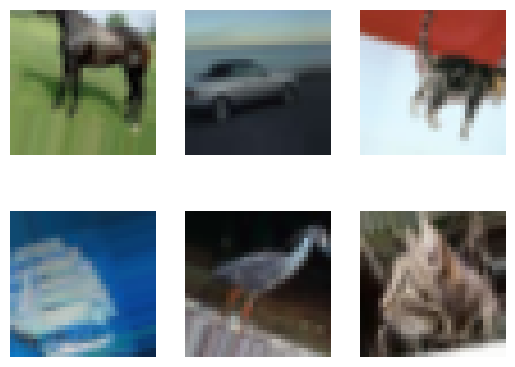

In [55]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()


datagen = keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

datagen.fit(x_train)

for X_batch, y_batch in datagen.flow(x_train,y_train, batch_size=6):
    for i in range(0, 6):
        plt.subplot(2,3,i+1)
        plt.imshow(X_batch[i]/255)
        plt.axis('off')
    break

In [56]:
class RandomInvert(layers.Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return random_invert_img(x)

In [57]:
_ = plt.imshow(RandomInvert()(image)[0])

NameError: ignored

In [58]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

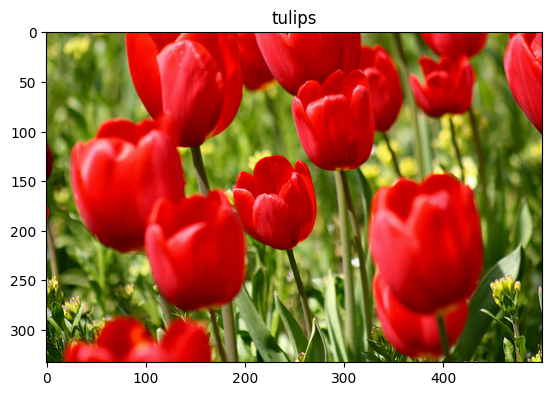

In [59]:
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

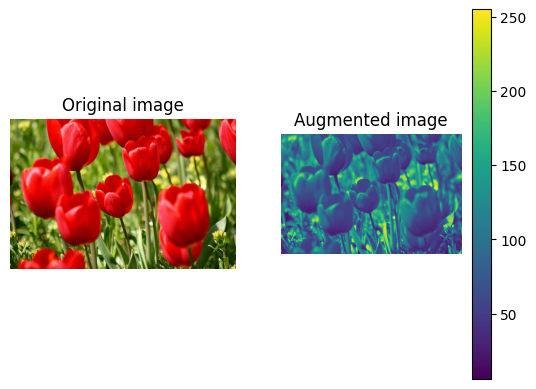

In [60]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
_ = plt.colorbar()